<a href="https://colab.research.google.com/github/aakankshch/Arkema/blob/main/CISC848Ver1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook is Third version
It consists Hydrogen Abstraction model which takes MACCS Fingerprints and Molecular Transfer Embeddings

## Loading&Exploring Data

In [ ]:
!pip install deepchem pubchempy rdkit

In [ ]:
#Installing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit import RDLogger
import pubchempy as pcp
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
import deepchem as dc
import torch
from transformers import BertTokenizer, BertModel,AutoTokenizer, AutoModel
#import time
#import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [9]:
file_path='/content/drive/Shareddrives/CHEG CISC 848/Manual Data Ver1.csv'
df = pd.read_csv(file_path)

In [12]:
df.head()

,Name,Canonical SMILES,k,pH,Rxn Type,source,Comments:
0,acetanilide,CC(=O)Nc1ccccc1,5.000000e+09,9,Addition,NIST,NaN
1,acetophenone,CC(=O)c1ccccc1,6.500000e+09,7,Addition,NIST,NaN
2,acetophenone,CC(=O)c1ccccc1,4.800000e+09,9,Addition,NIST,NaN
3,acrylamide,C=CC(N)=O,3.300000e+09,10.7,Addition,NIST,NaN
4,acrylamide,C=CC(N)=O,4.700000e+09,6,Addition,NIST,NaN


In [11]:
df.info()
new_column_name = {'k (M^-1 s^-1)': 'k'}
df.rename(columns=new_column_name, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              562 non-null    object 
 1   Canonical SMILES  562 non-null    object 
 2   k (M^-1 s^-1)     562 non-null    float64
 3   pH                562 non-null    object 
 4   Rxn Type          562 non-null    object 
 5   source            562 non-null    object 
 6   Comments:         17 non-null     object 
dtypes: float64(1), object(6)
memory usage: 30.9+ KB


In [13]:
new_order=["Name","Canonical SMILES","pH","k","Rxn Type"]
df=df[new_order]
df.head()

,Name,Canonical SMILES,pH,k,Rxn Type
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,Addition
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,Addition
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,Addition
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,Addition
4,acrylamide,C=CC(N)=O,6,4.700000e+09,Addition


In [14]:
#Check for Missing Values
df.isnull().sum()

,0
Name,0
Canonical SMILES,0
pH,0
k,0
Rxn Type,0


In [15]:
df.duplicated().sum()
# Display duplicate rows
# df[df.duplicated(keep=False)]

np.int64(0)

In [17]:
#Drop Duplicates
df = df.drop_duplicates()
print(df.shape)

(562, 5)


No Duplicates were found

In [18]:
# Extract unique reactant names
reactant_names = df["Name"].dropna().unique()

In [19]:
#Filtering the Rxn Type
df_filtered = df[df['Rxn Type'] == 'Hydrogen Abstraction']
print(f"Rows and Columns after filtering: {df_filtered.shape}")
df_filtered.head()

Rows and Columns after filtering: (229, 5)


,Name,Canonical SMILES,pH,k,Rxn Type
78,methanol,CO,2,7.480000e+09,Hydrogen Abstraction
79,methanol,CO,6,8.600000e+08,Hydrogen Abstraction
80,methanol,CO,7,7.740000e+09,Hydrogen Abstraction
81,methanol,CO,9,1.040000e+09,Hydrogen Abstraction
82,methanol,CO,10.5,9.500000e+08,Hydrogen Abstraction


In [20]:
#Just changing df_filtered to df
df=df_filtered.copy()

In [21]:
df['pH'].unique()

array(['2', '6', '7', '9', '10.5', '3', '5', '8.55', '1', 'acid', '10.7',
       '13', '8.5', '6.5', '1.2', '12', '5.5', 'alk', '10', '11', '6.25',
       '2.4'], dtype=object)

In [23]:
print(df[df["pH"].isin(["acid", "alk"])].shape)
df[df["pH"].isin(["acid", "alk"])]

(2, 5)


,Name,Canonical SMILES,pH,k,Rxn Type
152,Formic Acid,O=CO,acid,1.530000e+08,Hydrogen Abstraction
375,hydrogen sulfide,S,alk,9.000000e+09,Hydrogen Abstraction


In [26]:
#Filter the Dataframe by removing the rows
df = df[~df["pH"].isin(["acid", "alk"])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227 entries, 78 to 387
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              227 non-null    object 
 1   Canonical SMILES  227 non-null    object 
 2   pH                227 non-null    object 
 3   k                 227 non-null    float64
 4   Rxn Type          227 non-null    object 
dtypes: float64(1), object(4)
memory usage: 10.6+ KB


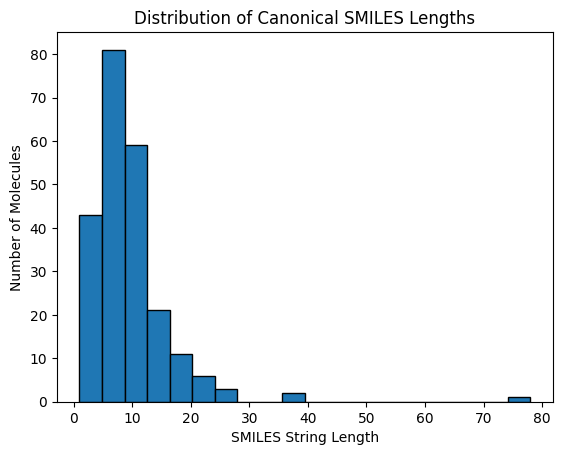

In [27]:
df["SMILES_Length"] = df["Canonical SMILES"].apply(lambda x: len(x) if x != "Not Found" else 0)

plt.hist(df["SMILES_Length"], bins=20, edgecolor="black")
plt.xlabel("SMILES String Length")
plt.ylabel("Number of Molecules")
plt.title("Distribution of Canonical SMILES Lengths")
plt.show()


In [30]:
df_long_smiles = df[df["SMILES_Length"] > 100]
print(df_long_smiles[["Name", "Canonical SMILES"]])
print(len(df_long_smiles))

Empty DataFrame
Columns: [Name, Canonical SMILES]
Index: []
0


There were no long smiles

## Feature Extraction

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227 entries, 78 to 387
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              227 non-null    object 
 1   Canonical SMILES  227 non-null    object 
 2   pH                227 non-null    object 
 3   k                 227 non-null    float64
 4   Rxn Type          227 non-null    object 
 5   SMILES_Length     227 non-null    int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 12.4+ KB


In [32]:
# Generate RDKit molecules from SMILES
df["Mol"] = df["Canonical SMILES"].apply(lambda x: Chem.MolFromSmiles(x) if pd.notnull(x) else None)

In [33]:
df.head()

,Name,Canonical SMILES,pH,k,Rxn Type,SMILES_Length,Mol
78,methanol,CO,2,7.480000e+09,Hydrogen Abstraction,2,<rdkit.Chem.rdchem.Mol object at 0x7b04eb707610>
79,methanol,CO,6,8.600000e+08,Hydrogen Abstraction,2,<rdkit.Chem.rdchem.Mol object at 0x7b04e96059a0>
80,methanol,CO,7,7.740000e+09,Hydrogen Abstraction,2,<rdkit.Chem.rdchem.Mol object at 0x7b04e9605700>
81,methanol,CO,9,1.040000e+09,Hydrogen Abstraction,2,<rdkit.Chem.rdchem.Mol object at 0x7b04e9605620>
82,methanol,CO,10.5,9.500000e+08,Hydrogen Abstraction,2,<rdkit.Chem.rdchem.Mol object at 0x7b04e9605770>


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227 entries, 78 to 387
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              227 non-null    object 
 1   Canonical SMILES  227 non-null    object 
 2   pH                227 non-null    object 
 3   k                 227 non-null    float64
 4   Rxn Type          227 non-null    object 
 5   SMILES_Length     227 non-null    int64  
 6   Mol               227 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 14.2+ KB


In [35]:
# Compute MACCS Fingerprints
def get_maccs_fingerprint(mol):
    if mol:
        return list(MACCSkeys.GenMACCSKeys(mol))  # Convert to list
    else:
        return [np.nan] * 167  # MACCS has 167 bits

In [36]:
df["MACCS"] = df["Mol"].apply(get_maccs_fingerprint)

In [37]:
df.head()

,Name,Canonical SMILES,pH,k,Rxn Type,SMILES_Length,Mol,MACCS
78,methanol,CO,2,7.480000e+09,Hydrogen Abstraction,2,<rdkit.Chem.rdchem.Mol object at 0x7b04eb707610>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
79,methanol,CO,6,8.600000e+08,Hydrogen Abstraction,2,<rdkit.Chem.rdchem.Mol object at 0x7b04e96059a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
80,methanol,CO,7,7.740000e+09,Hydrogen Abstraction,2,<rdkit.Chem.rdchem.Mol object at 0x7b04e9605700>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
81,methanol,CO,9,1.040000e+09,Hydrogen Abstraction,2,<rdkit.Chem.rdchem.Mol object at 0x7b04e9605620>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
82,methanol,CO,10.5,9.500000e+08,Hydrogen Abstraction,2,<rdkit.Chem.rdchem.Mol object at 0x7b04e9605770>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [40]:
df.shape

(227, 8)

In [41]:
# Convert list of fingerprints to separate columns
maccs_df = df["MACCS"].apply(pd.Series)

# Rename columns for clarity
maccs_df.columns = [f"MACCS_{i}" for i in range(167)]

# Merge with original data
df_final = pd.concat([df.drop(columns=["Mol", "MACCS"]), maccs_df], axis=1)

In [42]:
df_final.head()

,Name,Canonical SMILES,pH,k,Rxn Type,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,...,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166
78,methanol,CO,2,7.480000e+09,Hydrogen Abstraction,2,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
79,methanol,CO,6,8.600000e+08,Hydrogen Abstraction,2,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
80,methanol,CO,7,7.740000e+09,Hydrogen Abstraction,2,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
81,methanol,CO,9,1.040000e+09,Hydrogen Abstraction,2,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
82,methanol,CO,10.5,9.500000e+08,Hydrogen Abstraction,2,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0


In [44]:
#No null values are found
df_final.isnull().sum().sum()
# df_final.isnull().sum()
# df_final[df_final["MACCS_0"].isnull()]

np.int64(0)

In [47]:
# Drop rows where any MACCS descriptor is NaN
df_final_cleaned = df_final.dropna()

# Reset the index after dropping rows
df_final_cleaned.reset_index(drop=True, inplace=True)

df_final_cleaned.isnull().sum().sum()

In [53]:
# Convert all MACCS fingerprint columns to integers (0 or 1)
maccs_cols = [col for col in df_final_cleaned.columns if "MACCS_" in col]
df_final_cleaned[maccs_cols] = df_final_cleaned[maccs_cols].astype(int)

# Check the first few rows
df_final_cleaned.head()

,Name,Canonical SMILES,pH,k,Rxn Type,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,...,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166
0,methanol,CO,2,7.480000e+09,Hydrogen Abstraction,2,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
1,methanol,CO,6,8.600000e+08,Hydrogen Abstraction,2,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
2,methanol,CO,7,7.740000e+09,Hydrogen Abstraction,2,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
3,methanol,CO,9,1.040000e+09,Hydrogen Abstraction,2,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
4,methanol,CO,10.5,9.500000e+08,Hydrogen Abstraction,2,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0


In [54]:
df_final_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Columns: 173 entries, Name to MACCS_166
dtypes: float64(1), int64(168), object(4)
memory usage: 306.9+ KB


In [55]:
#Molecular Transfer Embeddings
# Load pre-trained ChemBERTa model (can use other molecular transformer models too)
model_name = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [56]:
# Function to get embeddings from SMILES
def get_molecular_embedding(smiles):
    if smiles is None or smiles == "":
        return None
    try:
        tokens = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            output = model(**tokens)
        return output.last_hidden_state.mean(dim=1).squeeze().numpy()  # Get mean-pooled embedding
    except:
        return None  # Handle errors


In [57]:
# Apply to dataset
df_final_cleaned["Transformer_Embedding"] = df_final_cleaned["Canonical SMILES"].apply(get_molecular_embedding)

In [58]:
df_final_cleaned.head()

,Name,Canonical SMILES,pH,k,Rxn Type,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,...,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166,Transformer_Embedding
0,methanol,CO,2,7.480000e+09,Hydrogen Abstraction,2,0,0,0,0,...,0,0,1,0,0,0,1,0,0,"[0.9756883, 2.0530708, -0.6217852, -2.459071, ..."
1,methanol,CO,6,8.600000e+08,Hydrogen Abstraction,2,0,0,0,0,...,0,0,1,0,0,0,1,0,0,"[0.9756883, 2.0530708, -0.6217852, -2.459071, ..."
2,methanol,CO,7,7.740000e+09,Hydrogen Abstraction,2,0,0,0,0,...,0,0,1,0,0,0,1,0,0,"[0.9756883, 2.0530708, -0.6217852, -2.459071, ..."
3,methanol,CO,9,1.040000e+09,Hydrogen Abstraction,2,0,0,0,0,...,0,0,1,0,0,0,1,0,0,"[0.9756883, 2.0530708, -0.6217852, -2.459071, ..."
4,methanol,CO,10.5,9.500000e+08,Hydrogen Abstraction,2,0,0,0,0,...,0,0,1,0,0,0,1,0,0,"[0.9756883, 2.0530708, -0.6217852, -2.459071, ..."


In [59]:
df_final_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Columns: 174 entries, Name to Transformer_Embedding
dtypes: float64(1), int64(168), object(5)
memory usage: 308.7+ KB


In [60]:
# Convert Transformer Embeddings column into separate features
embeddings_matrix = np.vstack(df_final_cleaned["Transformer_Embedding"].dropna().values)
embedding_df = pd.DataFrame(embeddings_matrix, columns=[f"Embedding_{i}" for i in range(embeddings_matrix.shape[1])])

# Merge with original dataset
df_final_embeddings = pd.concat([df_final_cleaned.reset_index(drop=True), embedding_df.reset_index(drop=True)], axis=1)

# Drop original Transformer Embedding column
df_final_embeddings.drop(columns=["Transformer_Embedding"], inplace=True)

In [61]:
df_final_embeddings.head()

,Name,Canonical SMILES,pH,k,Rxn Type,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,...,Embedding_758,Embedding_759,Embedding_760,Embedding_761,Embedding_762,Embedding_763,Embedding_764,Embedding_765,Embedding_766,Embedding_767
0,methanol,CO,2,7.480000e+09,Hydrogen Abstraction,2,0,0,0,0,...,-0.919288,1.242948,-0.691183,0.019527,-0.604418,-0.861532,-0.9017,-0.221981,-0.669586,0.521773
1,methanol,CO,6,8.600000e+08,Hydrogen Abstraction,2,0,0,0,0,...,-0.919288,1.242948,-0.691183,0.019527,-0.604418,-0.861532,-0.9017,-0.221981,-0.669586,0.521773
2,methanol,CO,7,7.740000e+09,Hydrogen Abstraction,2,0,0,0,0,...,-0.919288,1.242948,-0.691183,0.019527,-0.604418,-0.861532,-0.9017,-0.221981,-0.669586,0.521773
3,methanol,CO,9,1.040000e+09,Hydrogen Abstraction,2,0,0,0,0,...,-0.919288,1.242948,-0.691183,0.019527,-0.604418,-0.861532,-0.9017,-0.221981,-0.669586,0.521773
4,methanol,CO,10.5,9.500000e+08,Hydrogen Abstraction,2,0,0,0,0,...,-0.919288,1.242948,-0.691183,0.019527,-0.604418,-0.861532,-0.9017,-0.221981,-0.669586,0.521773


In [62]:
df_final_embeddings.isnull().sum().sum()

np.int64(0)

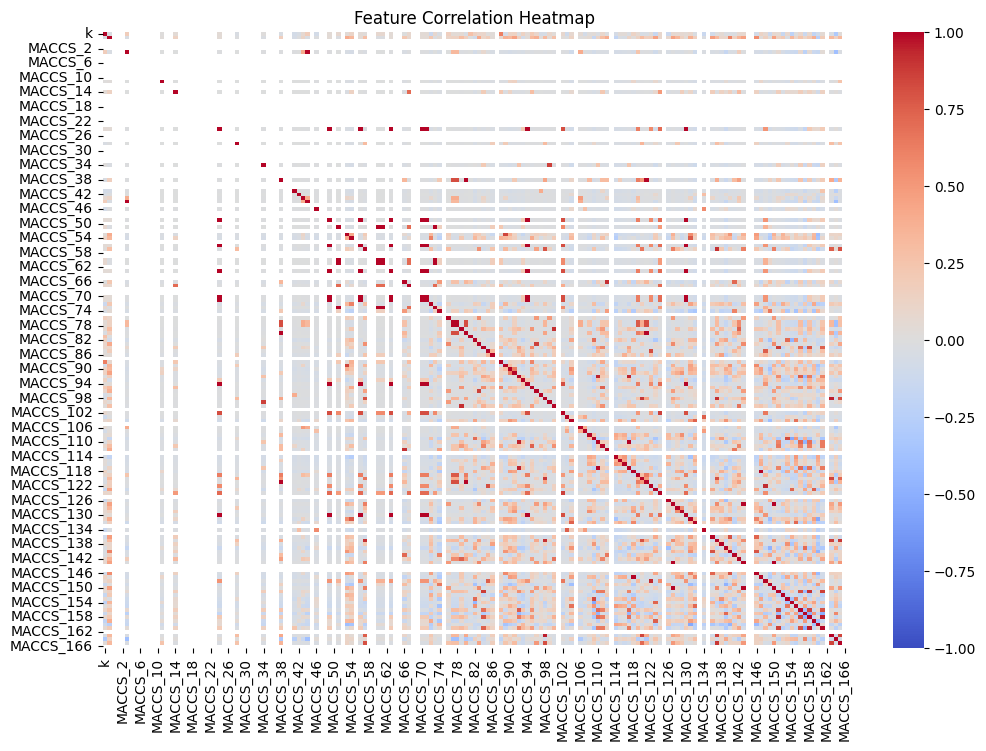

In [63]:
# Compute correlation matrix
numerical_df_MACCS = df_final_cleaned.select_dtypes(include=["float64","int64"])
correlation_matrix = numerical_df_MACCS.corr()

# Plot heatmap of top 50 features (for visualization clarity)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", vmax=1.0, vmin=-1.0, center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


In [64]:
# Set threshold for high correlation
corr_threshold = 0.85

# Identify highly correlated feature pairs
correlated_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
            correlated_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Convert correlated pairs into a DataFrame for better visualization
correlated_df = pd.DataFrame(correlated_pairs, columns=["Feature_1", "Feature_2", "Correlation_Value"])

# Sort by correlation value (highest first)
correlated_df = correlated_df.sort_values(by="Correlation_Value", ascending=False)


In [65]:
len(correlated_df)

62

In [66]:
# Identify unique features to remove
features_to_remove = set(correlated_df["Feature_1"])  # Keep only one from each pair
len(features_to_remove)

# Drop correlated features from dataset
df_reduced = df_final_cleaned.drop(columns=features_to_remove)

print(f"Removed {len(features_to_remove)} correlated features.")


Removed 32 correlated features.


In [67]:
embedding_df.head()
embedding_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Columns: 768 entries, Embedding_0 to Embedding_767
dtypes: float32(768)
memory usage: 681.1 KB


In [68]:
# Compute correlation matrix
correlation_matrix_em = embedding_df.corr()

# Set threshold for high correlation
corr_threshold = 0.85

# Identify highly correlated feature pairs
embedding_correlated_pairs = []

for i in range(len(correlation_matrix_em.columns)):
    for j in range(i):
        if abs(correlation_matrix_em.iloc[i, j]) > corr_threshold:
            embedding_correlated_pairs.append((correlation_matrix_em.columns[i],
                                               correlation_matrix_em.columns[j],
                                               correlation_matrix_em.iloc[i, j]))

# Convert to DataFrame for better visualization
embedding_correlated_df = pd.DataFrame(embedding_correlated_pairs,
                                       columns=["Feature_1", "Feature_2", "Correlation_Value"])

# Sort by correlation value (highest first)
embedding_correlated_df = embedding_correlated_df.sort_values(by="Correlation_Value", ascending=False)

In [69]:
# Identify unique features to remove (keep only one from each pair)
embedding_features_to_remove = set(embedding_correlated_df["Feature_1"])

# Drop correlated features from embeddings
embeddings_df_reduced = embedding_df.drop(columns=embedding_features_to_remove)

print(f"Removed {len(embedding_features_to_remove)} correlated embedding features.")

Removed 271 correlated embedding features.


In [70]:
embeddings_df_reduced.head()
df_reduced.head()

,Name,Canonical SMILES,pH,k,Rxn Type,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,...,MACCS_154,MACCS_155,MACCS_156,MACCS_157,MACCS_159,MACCS_160,MACCS_162,MACCS_164,MACCS_166,Transformer_Embedding
0,methanol,CO,2,7.480000e+09,Hydrogen Abstraction,2,0,0,0,0,...,0,0,0,1,0,1,0,1,0,"[0.9756883, 2.0530708, -0.6217852, -2.459071, ..."
1,methanol,CO,6,8.600000e+08,Hydrogen Abstraction,2,0,0,0,0,...,0,0,0,1,0,1,0,1,0,"[0.9756883, 2.0530708, -0.6217852, -2.459071, ..."
2,methanol,CO,7,7.740000e+09,Hydrogen Abstraction,2,0,0,0,0,...,0,0,0,1,0,1,0,1,0,"[0.9756883, 2.0530708, -0.6217852, -2.459071, ..."
3,methanol,CO,9,1.040000e+09,Hydrogen Abstraction,2,0,0,0,0,...,0,0,0,1,0,1,0,1,0,"[0.9756883, 2.0530708, -0.6217852, -2.459071, ..."
4,methanol,CO,10.5,9.500000e+08,Hydrogen Abstraction,2,0,0,0,0,...,0,0,0,1,0,1,0,1,0,"[0.9756883, 2.0530708, -0.6217852, -2.459071, ..."


In [71]:
# Merge with original dataset
df_final = pd.concat([df_reduced.reset_index(drop=True), embeddings_df_reduced.reset_index(drop=True)], axis=1)

# Drop original Transformer Embedding column
df_final.drop(columns=["Transformer_Embedding"], inplace=True)

In [72]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Columns: 638 entries, Name to Embedding_767
dtypes: float32(497), float64(1), int64(136), object(4)
memory usage: 690.9+ KB


In [73]:
df_final.head()

,Name,Canonical SMILES,pH,k,Rxn Type,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,...,Embedding_754,Embedding_756,Embedding_758,Embedding_760,Embedding_761,Embedding_762,Embedding_764,Embedding_765,Embedding_766,Embedding_767
0,methanol,CO,2,7.480000e+09,Hydrogen Abstraction,2,0,0,0,0,...,1.184965,1.451081,-0.919288,-0.691183,0.019527,-0.604418,-0.9017,-0.221981,-0.669586,0.521773
1,methanol,CO,6,8.600000e+08,Hydrogen Abstraction,2,0,0,0,0,...,1.184965,1.451081,-0.919288,-0.691183,0.019527,-0.604418,-0.9017,-0.221981,-0.669586,0.521773
2,methanol,CO,7,7.740000e+09,Hydrogen Abstraction,2,0,0,0,0,...,1.184965,1.451081,-0.919288,-0.691183,0.019527,-0.604418,-0.9017,-0.221981,-0.669586,0.521773
3,methanol,CO,9,1.040000e+09,Hydrogen Abstraction,2,0,0,0,0,...,1.184965,1.451081,-0.919288,-0.691183,0.019527,-0.604418,-0.9017,-0.221981,-0.669586,0.521773
4,methanol,CO,10.5,9.500000e+08,Hydrogen Abstraction,2,0,0,0,0,...,1.184965,1.451081,-0.919288,-0.691183,0.019527,-0.604418,-0.9017,-0.221981,-0.669586,0.521773


## Feature Engineering

In [74]:
# Apply natural logarithm transformation to k
df_final["ln_k"] = np.log(df_final["k"])

# Drop the original k column
df_final.drop(columns=["k"], inplace=True)

In [75]:
df_final.head()

,Name,Canonical SMILES,pH,Rxn Type,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,MACCS_4,...,Embedding_756,Embedding_758,Embedding_760,Embedding_761,Embedding_762,Embedding_764,Embedding_765,Embedding_766,Embedding_767,ln_k
0,methanol,CO,2,Hydrogen Abstraction,2,0,0,0,0,0,...,1.451081,-0.919288,-0.691183,0.019527,-0.604418,-0.9017,-0.221981,-0.669586,0.521773,22.735499
1,methanol,CO,6,Hydrogen Abstraction,2,0,0,0,0,0,...,1.451081,-0.919288,-0.691183,0.019527,-0.604418,-0.9017,-0.221981,-0.669586,0.521773,20.572443
2,methanol,CO,7,Hydrogen Abstraction,2,0,0,0,0,0,...,1.451081,-0.919288,-0.691183,0.019527,-0.604418,-0.9017,-0.221981,-0.669586,0.521773,22.769668
3,methanol,CO,9,Hydrogen Abstraction,2,0,0,0,0,0,...,1.451081,-0.919288,-0.691183,0.019527,-0.604418,-0.9017,-0.221981,-0.669586,0.521773,20.762487
4,methanol,CO,10.5,Hydrogen Abstraction,2,0,0,0,0,0,...,1.451081,-0.919288,-0.691183,0.019527,-0.604418,-0.9017,-0.221981,-0.669586,0.521773,20.671973


In [76]:
from sklearn.preprocessing import StandardScaler

# Identify columns to scale
embedding_cols = [col for col in df_final.columns if "Embedding_" in col]

# Initialize Scaler
scaler = StandardScaler()

# Apply Scaling to Embeddings Only
df_final[embedding_cols] = scaler.fit_transform(df_final[embedding_cols])

In [77]:
df_final.head()

,Name,Canonical SMILES,pH,Rxn Type,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,MACCS_4,...,Embedding_756,Embedding_758,Embedding_760,Embedding_761,Embedding_762,Embedding_764,Embedding_765,Embedding_766,Embedding_767,ln_k
0,methanol,CO,2,Hydrogen Abstraction,2,0,0,0,0,0,...,0.507242,-0.92552,-0.749223,0.794574,-1.132337,-0.506282,1.137137,-1.344491,-0.17967,22.735499
1,methanol,CO,6,Hydrogen Abstraction,2,0,0,0,0,0,...,0.507242,-0.92552,-0.749223,0.794574,-1.132337,-0.506282,1.137137,-1.344491,-0.17967,20.572443
2,methanol,CO,7,Hydrogen Abstraction,2,0,0,0,0,0,...,0.507242,-0.92552,-0.749223,0.794574,-1.132337,-0.506282,1.137137,-1.344491,-0.17967,22.769668
3,methanol,CO,9,Hydrogen Abstraction,2,0,0,0,0,0,...,0.507242,-0.92552,-0.749223,0.794574,-1.132337,-0.506282,1.137137,-1.344491,-0.17967,20.762487
4,methanol,CO,10.5,Hydrogen Abstraction,2,0,0,0,0,0,...,0.507242,-0.92552,-0.749223,0.794574,-1.132337,-0.506282,1.137137,-1.344491,-0.17967,20.671973


In [78]:
# Ensure MACCS fingerprints are integers (binary features)
maccs_cols = [col for col in df_final.columns if "MACCS_" in col]
df_final[maccs_cols] = df_final[maccs_cols].astype(int)

# Ensure embedding columns are floats
embedding_cols = [col for col in df_final.columns if "Embedding_" in col]
df_final[embedding_cols] = df_final[embedding_cols].astype(float)

In [79]:
#Ensuring proper Data Types
df_final["pH"] = df_final["pH"].astype(float)

In [80]:
print(df_final.dtypes)

Name                 object
Canonical SMILES     object
pH                  float64
Rxn Type             object
SMILES_Length         int64
                     ...   
Embedding_764       float64
Embedding_765       float64
Embedding_766       float64
Embedding_767       float64
ln_k                float64
Length: 638, dtype: object


In [81]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Columns: 638 entries, Name to ln_k
dtypes: float64(499), int64(136), object(3)
memory usage: 1.1+ MB


## Model Training

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error

In [83]:
# Define input features (excluding non-numeric columns)
X = df_final.drop(columns=["Name", "Canonical SMILES","Rxn Type","ln_k"])  # Features
y = df_final["ln_k"]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [84]:
X_train.head()

,pH,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,MACCS_6,MACCS_7,...,Embedding_754,Embedding_756,Embedding_758,Embedding_760,Embedding_761,Embedding_762,Embedding_764,Embedding_765,Embedding_766,Embedding_767
60,7.0,8,0,0,0,0,0,0,0,0,...,1.981502,0.082092,0.246666,-0.233516,-0.206151,-0.135413,-0.404810,-2.119608,0.059147,1.173995
164,9.0,5,0,0,0,0,0,0,0,0,...,0.103816,0.254284,-1.468228,-0.360509,0.791150,-0.986184,-0.440341,1.280971,-1.252587,-0.752706
68,9.0,13,0,0,0,0,0,0,0,0,...,0.882073,-0.550232,-0.199110,-0.852702,-0.681508,0.094560,0.042756,-0.993778,-0.695853,1.119597
183,9.0,13,0,0,0,0,0,0,0,0,...,-0.585596,0.678471,1.477555,1.540265,-0.734122,2.944326,2.097308,0.650164,1.245428,0.158991
216,10.0,6,0,0,0,1,0,0,0,0,...,0.156957,-0.856570,-0.761035,4.890238,-0.704473,-0.269113,0.295828,-0.433362,1.951196,0.842850


In [85]:
# Initialize models
linear_model = LinearRegression()
lasso_model = Lasso(alpha=0.1)  # Alpha controls regularization strength
ridge_model = Ridge(alpha=1.0)

In [86]:
# Train models
linear_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)

Ridge()

In [87]:
# Make predictions
y_pred_linear = linear_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)

In [88]:
# Evaluate models
results = {
    "Model": ["Linear Regression", "Lasso Regression", "Ridge Regression"],
    "MAE": [
        mean_absolute_error(y_test, y_pred_linear),
        mean_absolute_error(y_test, y_pred_lasso),
        mean_absolute_error(y_test, y_pred_ridge),
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_linear)),
        np.sqrt(mean_squared_error(y_test, y_pred_lasso)),
        np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    ],
    "R² Score": [
        r2_score(y_test, y_pred_linear),
        r2_score(y_test, y_pred_lasso),
        r2_score(y_test, y_pred_ridge),
    ],
}

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

In [89]:
display(results_df)

,Model,MAE,RMSE,R² Score
0,Linear Regression,0.718289,0.983819,0.731305
1,Lasso Regression,1.209121,1.534304,0.346490
2,Ridge Regression,0.706989,0.979831,0.733479


In [90]:
# Initialize models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

In [91]:
# Train models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [92]:
# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

In [93]:
# Evaluate models
results_tree = {
    "Model": ["Random Forest", "XGBoost"],
    "MAE": [
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_xgb),
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    ],
    "R² Score": [
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_xgb),
    ],
}

In [94]:
results_tree

{'Model': ['Random Forest', 'XGBoost'],
 'MAE': [0.8326171483565045, 0.8031122697677696],
 'RMSE': [np.float64(1.0592990093521781), np.float64(1.1202178928696003)],
 'R² Score': [0.688494015839533, 0.6516351949227708]}

In [95]:
# Convert results to a DataFrame
results_tree = pd.DataFrame(results_tree)
display(results_tree)

,Model,MAE,RMSE,R² Score
0,Random Forest,0.832617,1.059299,0.688494
1,XGBoost,0.803112,1.120218,0.651635


In [96]:
# Merge the results
final_results = pd.concat([results_df, results_tree], ignore_index=True)

In [97]:
display(final_results)

,Model,MAE,RMSE,R² Score
0,Linear Regression,0.718289,0.983819,0.731305
1,Lasso Regression,1.209121,1.534304,0.346490
2,Ridge Regression,0.706989,0.979831,0.733479
3,Random Forest,0.832617,1.059299,0.688494
4,XGBoost,0.803112,1.120218,0.651635


### Delete Later

In [ ]:
# Define the molecular descriptors to compute
descriptor_names = [desc[0] for desc in Descriptors._descList]
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

In [ ]:
# Compute descriptors and store them in a new DataFrame
descriptor_data = []
for mol in df["Mol"]:
    if mol:
        descriptor_data.append(calculator.CalcDescriptors(mol))
    else:
        descriptor_data.append([None] * len(descriptor_names))

[17:11:56] WARNING: not removing hydrogen atom without neighbors
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
             ^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/rdkit/Chem/SpacialScore.py", line 72, in SPS
    return _SpacialScore(mol, normalize=normalize).score
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/rdkit/Chem/SpacialScore.py", line 95, in __init__
    self.score /= self.mol.GetNumHeavyAtoms()
ZeroDivisionError: division by zero
[17:11:56] WARNING: not removing hydrogen atom without neighbors
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
             ^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/rdkit/Chem/SpacialScore.py", line 72, in SP

In [ ]:
# Convert to DataFrame
descriptor_df = pd.DataFrame(descriptor_data, columns=descriptor_names)

# Merge with the original data
df_descriptors = pd.concat([df.drop(columns=["Mol"]), descriptor_df], axis=1)

In [ ]:
df_descriptors.head()

,Name,Canonical SMILES,pH,k,SMILES_Length,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,15.0,10.502041,10.502041,0.035926,-0.035926,0.622799,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,14.0,10.645370,10.645370,0.120926,0.120926,0.517047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,14.0,10.645370,10.645370,0.120926,0.120926,0.517047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,9.0,9.472222,9.472222,0.481481,-0.481481,0.421996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,acrylamide,C=CC(N)=O,6,4.700000e+09,9.0,9.472222,9.472222,0.481481,-0.481481,0.421996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df[df["Name"].isnull()]

,Name,Canonical SMILES,pH,k,SMILES_Length,Mol


In [ ]:
df_descriptors[df_descriptors["Name"].isnull()]

,Name,Canonical SMILES,pH,k,SMILES_Length,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
152,NaN,NaN,NaN,NaN,NaN,8.361111,8.361111,0.250000,-0.250000,0.380161,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
272,NaN,NaN,NaN,NaN,NaN,9.062500,9.062500,0.625000,0.625000,0.399917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
375,NaN,NaN,NaN,NaN,NaN,4.122685,4.122685,0.194444,0.194444,0.430050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
532,NaN,NaN,NaN,NaN,NaN,9.997826,9.997826,0.668633,-2.221748,0.237891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536,NaN,NaN,NaN,NaN,NaN,12.408729,12.408729,0.029454,-1.347366,0.284676,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
538,NaN,NaN,NaN,NaN,NaN,12.530603,12.530603,0.037140,-1.168657,0.614448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.iloc[[152, 272, 375, 532, 536, 538]]  # Check if these rows exist in df

,Name,Canonical SMILES,pH,k,SMILES_Length,Mol
153,Formic Acid,O=CO,7,2.760000e+09,4,<rdkit.Chem.rdchem.Mol object at 0x7fc5e3803d10>
274,N-methylformamide,CNC=O,5.5,1.200000e+09,5,<rdkit.Chem.rdchem.Mol object at 0x7fc5e3823220>
378,t-butylmercaptan,CC(C)(C)S,7,1.800000e+10,9,<rdkit.Chem.rdchem.Mol object at 0x7fc5e3845fc0>
537,sucrose,OCC1OC(OC2(CO)OC(CO)C(O)C2O)C(O)C(O)C1O,2,2.500000e+09,39,<rdkit.Chem.rdchem.Mol object at 0x7fc5e3842420>
542,eosin dianion,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,9,6.000000e+08,65,<rdkit.Chem.rdchem.Mol object at 0x7fc5e38425e0>
544,fluoroscein,O=C1OC2(c3ccc(O)cc3Oc3cc(O)ccc32)c2ccccc21,9.2,1.400000e+09,42,<rdkit.Chem.rdchem.Mol object at 0x7fc5e38426c0>


In [ ]:
#Dropping the probablamatic names
df_descriptors = df_descriptors.dropna(subset=["Name"])

In [ ]:
df_descriptors[df_descriptors["Name"].isnull()]

,Name,Canonical SMILES,pH,k,SMILES_Length,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea


In [ ]:
# Check how many descriptors are NaN
df_descriptors.isnull().sum()

,0
Name,0
Canonical SMILES,0
pH,0
k,0
SMILES_Length,0
...,...
fr_thiazole,9
fr_thiocyan,9
fr_thiophene,9
fr_unbrch_alkane,9
